<a href="https://colab.research.google.com/github/524429264/-/blob/master/pressure_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1 数据预处理

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

def load_and_preprocess_data(data_dir, num_frames=20, num_samples=8):
    X = []
    y = []
    for i in range(1, num_samples + 1):
        sample_dir = os.path.join(data_dir, f'sample_{i}')
        if os.path.isdir(sample_dir):
            frames = []
            for j in range(1, num_frames + 1):
                img_path = os.path.join(sample_dir, f'image_{j}.jpg')
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))  # 调整图像大小
                img = img / 255.0  # 归一化
                frames.append(img)

            X.append(np.array(frames))

            # 从label.txt文件读取最大爆炸压力
            with open(os.path.join(sample_dir, 'label.txt'), 'r') as f:
                max_pressure = float(f.read().strip())
            y.append(max_pressure)

    return np.array(X), np.array(y)

# 加载数据
X, y = load_and_preprocess_data('drive/My Drive/explosion_data', num_frames=20, num_samples=8)

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#2 模型架构设计


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, LSTM, Dense, Flatten, Dropout

def create_model(input_shape):
    model = Sequential([
        TimeDistributed(Conv2D(32, (3, 3), activation='relu'), input_shape=input_shape),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Conv2D(64, (3, 3), activation='relu')),
        TimeDistributed(MaxPooling2D((2, 2))),
        TimeDistributed(Flatten()),
        LSTM(100, return_sequences=True),
        Dropout(0.3),
        LSTM(50),
        Dense(32, activation='relu'),
        Dense(1)  # 输出最大爆炸压力
    ])
    return model

# 创建模型
input_shape = (20, 224, 224, 3)  # (num_frames, height, width, channels)
model = create_model(input_shape)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#3 模型训练


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 定义回调函数
early_stopping = EarlyStopping(patience=20, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=10, min_lr=1e-6)

# 训练模型
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=16,  # 由于样本数量少，使用小的batch size
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# 保存模型
model.save('flame_pressure_model.h5')

Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.0271 - mae: 0.1398 - val_loss: 3.5459e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 539ms/step - loss: 0.0231 - mae: 0.1218 - val_loss: 3.5475e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step - loss: 0.0230 - mae: 0.1409 - val_loss: 3.5491e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step - loss: 0.0189 - mae: 0.1183 - val_loss: 3.5510e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 621ms/step - loss: 0.0171 - mae: 0.1234 - val_loss: 3.5532e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step - loss: 0.0180 - mae: 0.1204 - val_loss: 3.5557e-04 - val_mae: 0.0188 - learning_rate: 1.6000e-06
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step - loss: 0.0225 - mae: 0.1404 - val_loss: 3.5585e-04 - val_

#4 模型评估


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - loss: 0.0023 - mae: 0.0475
Test Loss: 0.0022810311056673527, Test MAE: 0.047467321157455444


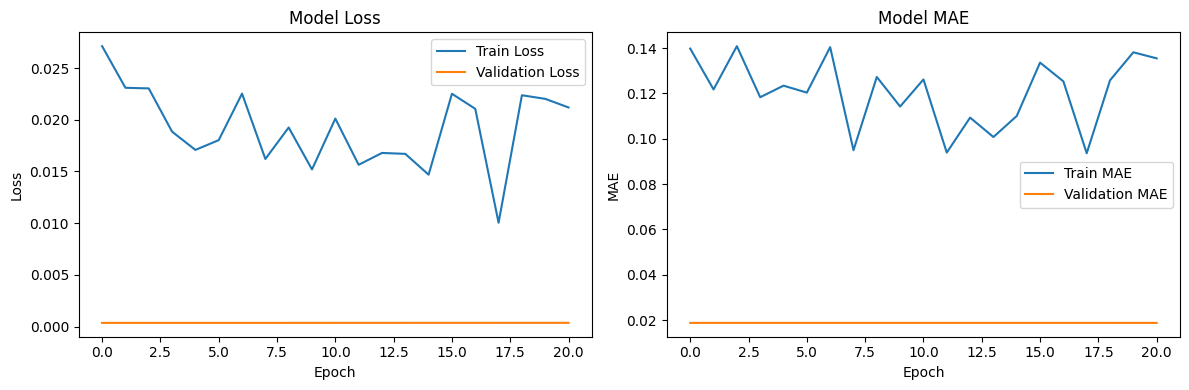

In [ ]:
# 评估模型
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

# 可视化训练过程
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

#5 预测功能


In [ ]:
def predict_max_pressure(model, image_sequence):
    # 预处理图像序列
    processed_sequence = []
    for img in image_sequence:
        img = cv2.resize(img, (224, 224))
        img = img / 255.0
        processed_sequence.append(img)

    # 将处理后的序列转换为numpy数组
    input_data = np.array([processed_sequence])

    # 使用模型进行预测
    predicted_pressure = model.predict(input_data)[0][0]

    return predicted_pressure

# 示例使用
def load_test_sequence(test_folder, num_frames=20):
    image_files = [f'image_{i}.jpg' for i in range(1, num_frames + 1)]
    return [cv2.imread(os.path.join(test_folder, f)) for f in image_files]

# 加载测试序列
test_sequence = load_test_sequence('drive/My Drive/explosion_testdata/sample_1', num_frames=20)

# 预测最大爆炸压力
predicted_pressure = predict_max_pressure(model, test_sequence)
print(f"Predicted maximum explosion pressure: {predicted_pressure}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Predicted maximum explosion pressure: 0.7179197072982788
